In [4]:
import time 

In [5]:
import numpy 
import torch

In [6]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Ti Laptop GPU
Using device: cuda


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, Normalize, ToTensor

from google.colab.patches import cv2_imshow  # For displaying images in Colab

## Midas

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Depth map computed in 16.94 seconds.


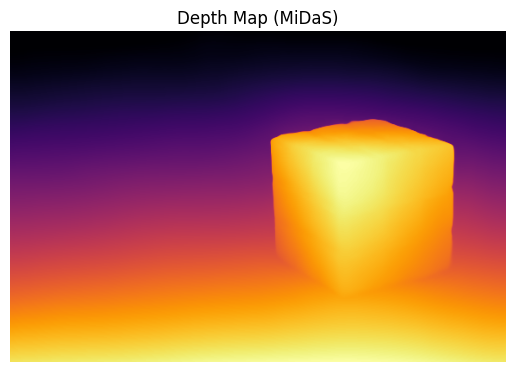

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

def load_midas_model(model_type="DPT_Large"):
    """
    Load MiDaS model and transforms.
    """
    model = torch.hub.load("intel-isl/MiDaS", model_type)
    model.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    if model_type in ["DPT_Large", "DPT_Hybrid"]:
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    return model, transform

def run_midas(image_path, model, transform, model_type="DPT_Large"):
    """
    Use MiDaS to perform monocular depth estimation.
    """

    # Load and transform the input image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at path: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply MiDaS preprocessing transforms
    input_batch = transform(img)

    # Run inference
    with torch.no_grad():
        depth = model(input_batch)

    # Convert depth map to numpy
    depth_map = depth.squeeze().cpu().numpy()

    # Normalize for visualization
    depth_min = depth_map.min()
    depth_max = depth_map.max()
    depth_normalized = (depth_map - depth_min) / (depth_max - depth_min)

    return depth_normalized

# Example usage
image_path = "cube.jpg"

model, transform = load_midas_model()

import time
start = time.time()
depth_map = run_midas(image_path, model, transform)
end = time.time()

print(f"Depth map computed in {end - start:.2f} seconds.")

# Display the depth map
plt.imshow(depth_map, cmap="inferno")
plt.title("Depth Map (MiDaS)")
plt.axis("off")
plt.show()


### 1.
- high resultion photo : chess.jpg
- CPU time: 20 seconds

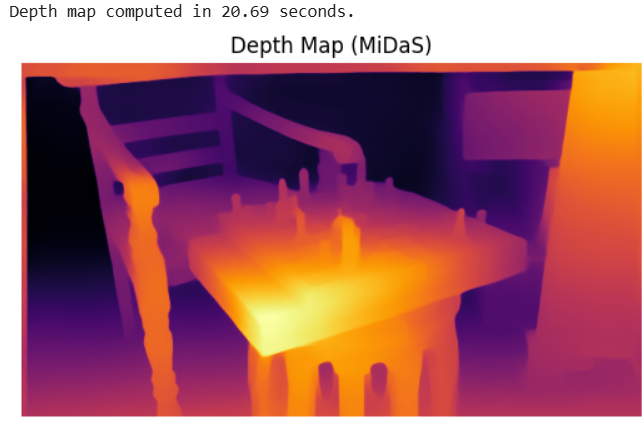

### 2.
- low resultion photo: chess1_r.jpg
- CPU time: 21s

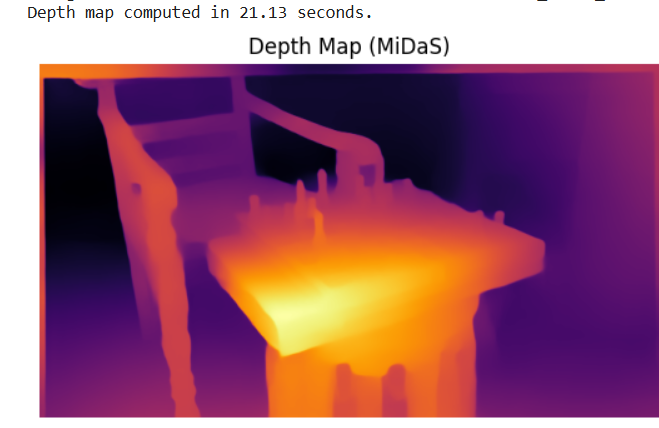

### 3.
- high resolution photo: chess.jpg
- GPU time: 8s

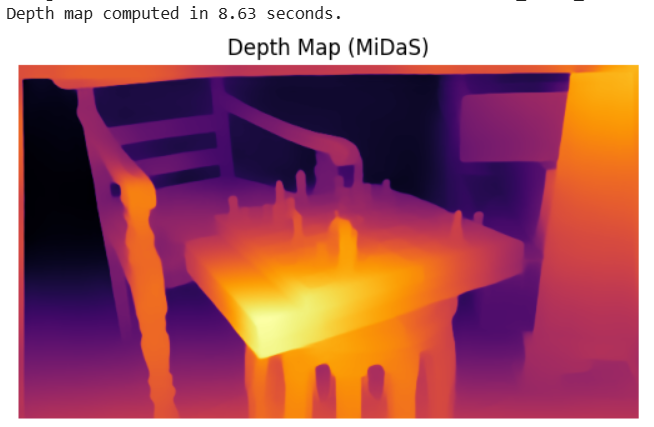

### 4.
- low resolution photo: chess_r.jpg
- GPU time: 9s

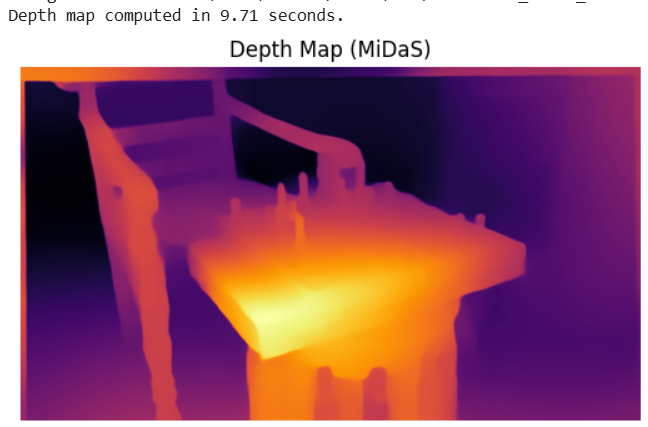

### 1. Sobel technique

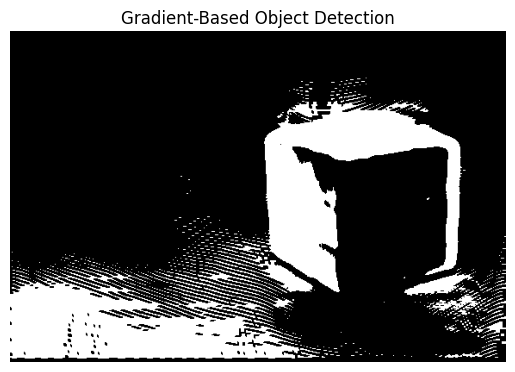

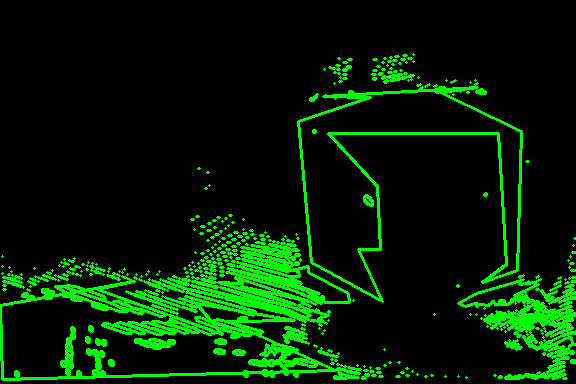

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assume depth_map is the input normalized depth map (0–1)
smoothed_depth = cv2.GaussianBlur(depth_map, (5, 5), 0)
depth_map_8bit = (smoothed_depth * 255).astype(np.uint8)
depth_map_8bit = cv2.bilateralFilter(depth_map_8bit, 9, 75, 75)
depth_map_8bit = cv2.medianBlur(depth_map_8bit, 5)

# Compute gradients
sobel_x = cv2.Sobel(depth_map_8bit, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(depth_map_8bit, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)

# Normalize and threshold the gradient
gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)

# Step 4: Apply morphological closing to clean up edges
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#cleaned_edges = cv2.morphologyEx(gradient_magnitude, cv2.MORPH_CLOSE, kernel)
kernel_size = 5  # Kernel size (adjustable)
mean_filtered = cv2.blur(gradient_magnitude, (kernel_size, kernel_size))

_, binary_edges = cv2.threshold(mean_filtered, 5, 255, cv2.THRESH_BINARY)

# Visualize results
plt.imshow(binary_edges, cmap="gray")
plt.title("Gradient-Based Object Detection")
plt.axis("off")
plt.show()

depth_map_binary = binary_edges.astype(np.uint8)

contours, hierarchy = cv2.findContours(depth_map_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

approx_polygons = []  # Store approximated polygons
corner_infos = [] # To store infromation about corners
contour_types = []    # Store types of contours ('hole' or 'object')

for contour in contours:
    # Approximate polygon for the contour
    epsilon = 1.0 * cv2.arcLength(contour, True)  # Adjust epsilon multiplier as needed
    approx = cv2.approxPolyDP(contour, epsilon, True)
    approx_polygons.append(approx)
    corner_infos.append([])

    # Determine contour type based on area
    area = cv2.contourArea(contour)
    contour_types.append('hole' if area < 0 else 'object')
    for i in range(len(approx)): # Analyze each corner
      p2 = approx[i][0]      # Current point (corner)
      corner_infos[-1].append({"pos": tuple(p2)}) # Append the results (corner position, type, slope change)

display_approximated_polygons(binary_edges)

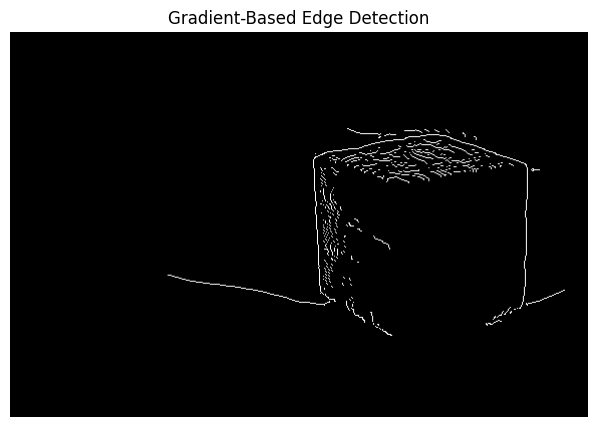

In [ ]:
depth_map_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
depth_map_8bit = (depth_map_normalized * 255).astype(np.uint8)
edges = cv2.Canny(depth_map_8bit, 1, 12)  # Threshold values are adjustable

# Display
plt.figure(figsize=(10, 5))
plt.imshow(edges, cmap="gray")
plt.title("Gradient-Based Edge Detection")
plt.axis("off")
plt.show()


0.49181044
108565
112619


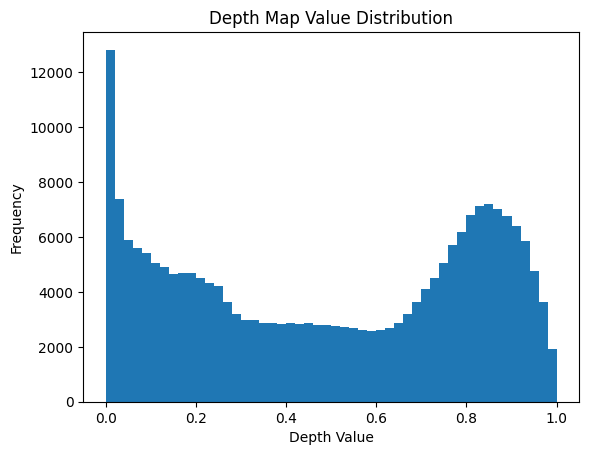

Optimal Otsu Threshold: [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


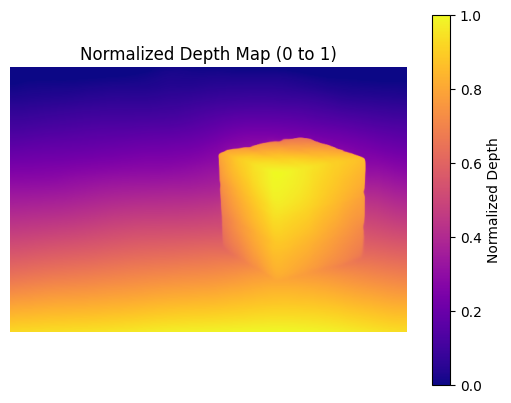

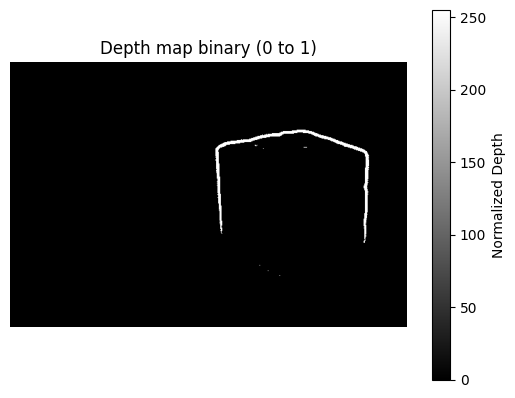

Detected 11 contours.


In [ ]:
def analyze_depth_map(depth_map):
    """
    Analyze the depth map by detecting contours, approximating polygons,
    and identifying convexities/concavities.

    Parameters:
        depth_map (numpy.ndarray): Input depth map.

    Returns:
        contours (list): Contours detected in the depth map.
        approx_polygons (list): Approximated polygons for each contour.
        contour_types (list): Types of contours ('hole' or 'object').
    """
    # Normalize the depth map to [0, 1]
    depth_map_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    assert np.max(depth_map_normalized) <= 1 and np.min(depth_map_normalized) >= 0

    #show me the mean of the pixels
    print(np.mean(depth_map_normalized))
    # show how many pixels values below mean how many above
    print(np.sum(depth_map_normalized < np.mean(depth_map_normalized)))
    print(np.sum(depth_map_normalized > np.mean(depth_map_normalized)))

    plt.hist(depth_map_normalized.ravel(), bins=50, range=(depth_map_normalized.min(), depth_map_normalized.max()))
    plt.title("Depth Map Value Distribution")
    plt.xlabel("Depth Value")
    plt.ylabel("Frequency")
    plt.show()


    # Convert depth map to binary using thresholding
    #threshold_value = 0.5  # Adjust this threshold based on your application
    #threshold_value = 0.6
    #_, depth_map_binary = cv2.threshold(depth_map_normalized, threshold_value, 1, cv2.THRESH_BINARY)
    #depth_map_binary = cv2.adaptiveThreshold(depth_map.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
    #        cv2.THRESH_BINARY,5,2)
    #depth_map_binary = depth_map_binary.astype(np.uint8)

    # Convert depth map to binary (thresholding)
    depth_map_8bit = (depth_map_normalized * 255).astype(np.uint8)
    depth_map_8bit = cv2.equalizeHist(depth_map_8bit)
    depth_map_smoothed = cv2.GaussianBlur(depth_map_8bit, (5, 5), 0)
    depth_map_binary = ((depth_map_smoothed > 0.3 *255) & (depth_map_smoothed < 0.6*255)).astype(np.uint8) * 255

    # Apply Otsu's thresholding
    _, otsu_threshold = cv2.threshold(
    depth_map_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    print(f"Optimal Otsu Threshold: {otsu_threshold}")

    #depth_map_binary = (depth_map_8bit > otsu_threshold).astype(np.uint8) * 255


    depth_map_binary = cv2.adaptiveThreshold(
    depth_map_smoothed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    inverted_depth_map_binary = cv2.bitwise_not(depth_map_binary)

    #Display normalized depth map:
    plt.imshow(depth_map_normalized, cmap="plasma")  # Or use 'inferno', 'viridis', etc.
    plt.colorbar(label="Normalized Depth")
    plt.title("Normalized Depth Map (0 to 1)")
    plt.axis("off")
    plt.show()
    #Display binary depth map:
    plt.imshow(inverted_depth_map_binary, cmap="gray")  # Or use 'inferno', 'viridis', etc.
    plt.colorbar(label="Normalized Depth")
    plt.title("Depth map binary (0 to 1)")
    plt.axis("off")
    plt.show()

    # Find contours
    inverted_depth_map_binary = inverted_depth_map_binary.astype(np.uint8)
    contours, hierarchy = cv2.findContours(depth_map_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    approx_polygons = []  # Store approximated polygons
    corner_infos = [] # To store infromation about corners
    contour_types = []    # Store types of contours ('hole' or 'object')

    for contour in contours:
        # Approximate polygon for the contour
        epsilon = 1.0 * cv2.arcLength(contour, True)  # Adjust epsilon multiplier as needed
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approx_polygons.append(approx)
        corner_infos.append([])

        # Determine contour type based on area
        area = cv2.contourArea(contour)
        contour_types.append('hole' if area < 0 else 'object')
        for i in range(len(approx)): # Analyze each corner
          p2 = approx[i][0]      # Current point (corner)
          corner_infos[-1].append({"pos": tuple(p2)}) # Append the results (corner position, type, slope change)

    return contours, approx_polygons, corner_infos, contour_types, depth_map_binary

# Example usage
contours, approx_polygons, corner_infos, contour_types, depth_map_binary = analyze_depth_map(depth_map)

print(f"Detected {len(contours)} contours.")



Two functions combined

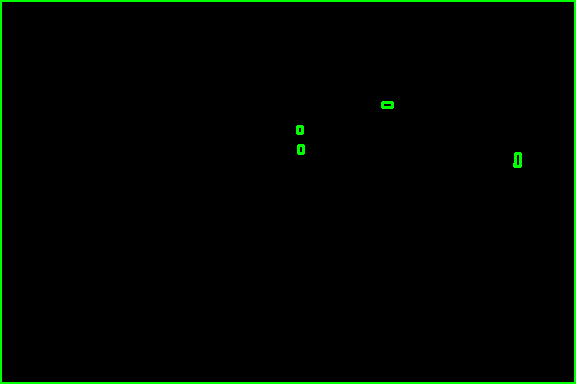

In [ ]:
def display_approximated_polygons(depth_map_binary):
    """
    Display approximated polygons on a depth map or binary image.

    Parameters:
        depth_map (numpy.ndarray): Input depth map.
    """
    # Create an image to visualize the polygons
    visualization_image = np.zeros_like(depth_map_binary)
    visualization_image = cv2.cvtColor(visualization_image, cv2.COLOR_GRAY2BGR)

    for contour in contours:
        # Approximate the polygon for each contour
        epsilon = 0.01 * cv2.arcLength(contour, True)  # Adjust epsilon as needed
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Draw the approximated polygon on the visualization image
        cv2.drawContours(visualization_image, [approx], -1, (0, 255, 0), 2)  # Green color for polygons

    # Display the image with approximated polygons
    cv2_imshow(visualization_image)

# Example usage
display_approximated_polygons(binary_edges)


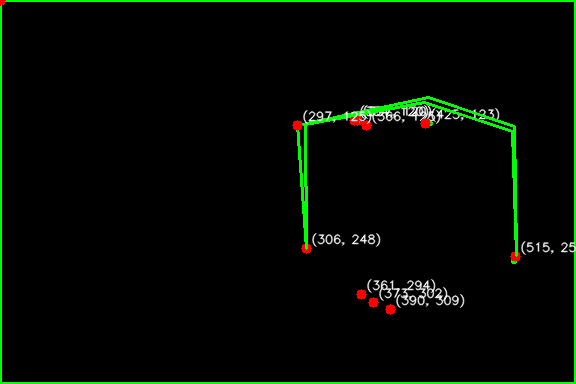

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # For displaying images in Google Colab

def display_approximated_polygons_and_corners(depth_map_binary, contours, corner_infos):
    """
    Display approximated polygons and their corners on a depth map or binary image.

    Parameters:
        depth_map_binary (numpy.ndarray): Input binary depth map.
        contours (list): List of contours detected in the image.
        corner_infos (list): Information about corners for each contour.
    """

    # Create an image to visualize the polygons
    visualization_image = np.zeros_like(depth_map_binary)
    visualization_image = cv2.cvtColor(visualization_image, cv2.COLOR_GRAY2BGR)

    for i, contour in enumerate(contours):
        # Approximate the polygon for the contour
        epsilon = 0.01 * cv2.arcLength(contour, True)  # Adjust epsilon as needed
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Draw the approximated polygon on the visualization image
        cv2.drawContours(visualization_image, [approx], -1, (0, 255, 0), 2)  # Green color for polygons

        # Draw corner points
        for corner_info in corner_infos[i]:  # Each corner_info corresponds to a polygon
            corner_pos = corner_info["pos"]  # Extract corner position (x, y)
            cv2.circle(visualization_image, corner_pos, 5, (0, 0, 255), -1)  # Red circle for corners

            # Optionally, display corner coordinates as text
            cv2.putText(
                visualization_image,
                f"{corner_pos}",
                (corner_pos[0] + 5, corner_pos[1] - 5),  # Offset text slightly
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,  # Font scale
                (255, 255, 255),  # White color
                1,  # Thickness
                cv2.LINE_AA
            )

    # Display the image with polygons and corners
    cv2_imshow(visualization_image)

display_approximated_polygons_and_corners(depth_map_binary, contours, corner_infos)
